## Normal VAE

In [1]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp


import genjax
from genjax import dippl
from genjax import gensp
from genjax import select

import adevjax


RESULTS_DIR = os.path.abspath(
    os.path.join(os.path.dirname(inspect.getfile(lambda: None)), ".results")
)
os.makedirs(RESULTS_DIR, exist_ok=True)

hidden_dim = 400
z_dim = 10
learning_rate = 1.0e-3
batch_size = 64
num_epochs = 50


def encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


def decoder(hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
    )


tfp_flip = genjax.TFPDistribution(
    lambda logits: tfp.distributions.Bernoulli(logits=logits)
)

# Define our gradient estimator using our loss language.
def svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        img_chm = genjax.value_choice_map(
            genjax.choice_map({"image": data.reshape((28 * 28,))})
        )

        @adevjax.adev
        def elbo_loss(encoder_params, decoder_params):
            key = adevjax.grab_key()
            w_q, latent_chm = guide.random_weighted(key, encoder_params, img_chm)
            merged = gensp.merge(latent_chm, img_chm)
            key = adevjax.grab_key()
            w_p = model.estimate_logpdf(key, merged, decoder_params)
            return w_p - w_q

        # @dippl.loss
        # def vae_loss(encoder, decoder):
        #    tgt = gensp.target(model, (decoder, ), img_chm)
        #    key = adevjax.grab_key()
        #    w = dippl.iwae_importance(10, guide, (encoder, v_chm)).estimate_normalizing_constant(key, tgt)
        #    return w

        loss, (encoder_params_grad, decoder_params_grad,) = adevjax.E(
            elbo_loss
        ).value_and_grad_estimate(key, (encoder_params, decoder_params))

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


@jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def decoder_model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    logits = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(logits) @ "image"


model = gensp.choice_map_distribution(decoder_model)


@genjax.gen
def encoder_model(encoder_params, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = dippl.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


guide = gensp.choice_map_distribution(encoder_model)

adam = optim.Adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


# Train.
key = random.PRNGKey(314159)
svi_state = adam.init((encoder_params, decoder_params))
for _ in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

-188.45569 -145.99301 -547.1345
-140.97702 -119.24007 -174.30585
-124.51519 -108.69387 -140.73648
-119.18571 -106.710434 -131.93222
-116.57622 -103.850105 -135.4164
-114.890366 -102.338036 -128.77405
-113.69138 -101.135124 -127.540215
-112.74176 -100.75715 -125.90066
-112.02653 -99.44371 -125.43559
-111.41506 -98.4425 -123.496666
-110.864624 -97.34712 -122.44699
-110.34374 -97.45987 -123.79559
-109.87392 -97.16034 -122.503365
-109.462845 -97.46684 -123.73362
-109.00539 -97.70998 -120.40784
-108.70409 -94.02933 -121.28646
-108.29771 -96.63216 -124.10054
-107.954475 -96.24721 -122.461754
-107.68379 -94.06569 -120.235146
-107.36504 -95.135635 -120.84753
-107.104675 -95.35954 -118.35329
-106.81925 -91.17453 -117.13491
-106.57731 -93.360176 -119.86782
-106.33779 -93.651695 -119.19004
-106.12617 -93.88286 -119.18097
-105.893074 -93.33822 -116.89662
-105.68713 -94.02281 -118.181015
-105.48719 -92.60289 -118.62013
-105.323494 -94.14931 -116.03696
-105.09678 -92.38104 -118.23361
-104.99719 -92.

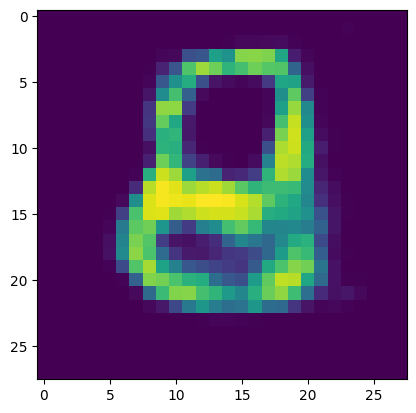

In [2]:
key, sub_key = jax.random.split(key)
_, updated_decoder_params = adam.get_params(svi_state)
latent = genjax.tfp_mv_normal_diag.sample(key, jnp.zeros(z_dim), jnp.ones(z_dim))
updated_out = jax.nn.sigmoid(decoder_nn_apply(updated_decoder_params, latent)).reshape(
    28, 28
)
plt.imshow(updated_out)

## IWAE

In [26]:
# Define our gradient estimator using our loss language.
def iwae_svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        img_chm = genjax.choice_map({"image": data.reshape((28 * 28,))})
        v_chm = genjax.value_choice_map(img_chm)

        @adevjax.adev
        def iwae_elbo_loss(encoder_params, decoder_params):
            tgt = gensp.target(model, (decoder_params,), img_chm)
            key = adevjax.grab_key()
            w = dippl.iwae_importance(
                10, guide, (encoder_params, v_chm)
            ).estimate_normalizing_constant(key, tgt)
            return w

        loss, (encoder_params_grad, decoder_params_grad) = adevjax.E(
            iwae_elbo_loss
        ).value_and_grad_estimate(key, (encoder_params, decoder_params))

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v, axis=0), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


adam = optim.Adam(learning_rate)
iwae_svi_updater = iwae_svi_update(decoder_model, guide, adam)

# Reset training.
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = iwae_svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


# Train.
key = random.PRNGKey(314159)
svi_state = adam.init((encoder_params, decoder_params))
for _ in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    num_train, train_idx = train_init()
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

-181.1488 -138.23373 -546.8816
-133.93814 -112.49797 -157.7378
-120.424095 -104.67554 -134.79227
-115.90752 -97.766495 -129.79495
-113.488144 -94.364105 -128.9044
-111.86609 -97.718094 -125.36744
-110.75377 -96.44031 -121.46252
-109.81511 -94.215164 -121.82553
-109.04724 -96.53082 -122.85661
-108.40413 -95.77434 -119.10558
-107.83351 -95.82615 -119.654465
-107.30721 -95.726364 -122.45939
-106.81892 -93.003525 -118.674065
-106.37071 -94.830025 -118.87111
-105.98047 -93.954834 -118.80867
-105.535194 -94.88811 -117.737335
-105.23241 -93.17256 -117.093155
-104.91289 -93.72701 -119.36119
-104.58419 -92.459335 -118.064316
-104.31425 -90.3069 -116.70206
-104.00726 -91.91431 -120.02371
-103.74803 -89.84543 -116.507645
-103.49905 -90.53998 -115.79309
-103.27224 -90.27301 -114.25046
-103.07239 -90.77635 -115.38422
-102.86862 -88.66402 -115.97076
-102.68913 -91.24543 -115.39569
-102.51083 -90.10745 -117.053535
-102.29615 -88.723434 -116.2702
-102.17691 -89.22943 -114.10457
-102.01707 -88.50029 -1

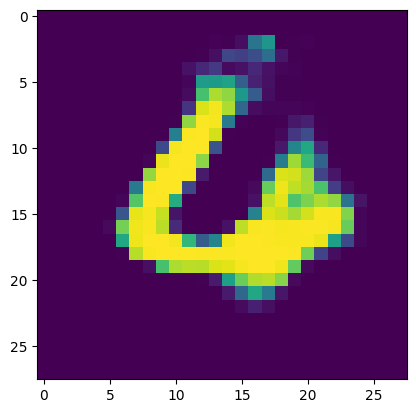

In [32]:
key, sub_key = jax.random.split(key)
_, updated_decoder_params = adam.get_params(svi_state)
latent = genjax.tfp_mv_normal_diag.sample(key, jnp.zeros(z_dim), jnp.ones(z_dim))
updated_out = jax.nn.sigmoid(decoder_nn_apply(updated_decoder_params, latent)).reshape(
    28, 28
)
plt.imshow(updated_out)